In [21]:
pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.5 MB 1.8 MB/s eta 0:00:01
   ----------- ---------------------------- 0.4/1.5 MB 3.8 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.5 MB 5.3 MB/s eta 0:00:01
   --------------------------------- ------ 1.2/1.5 MB 6.0 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.4/1.5 MB 6.1 MB/s eta 0:00:01
   -----------------------


Starting model training...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Model training completed in 2.8 minutes
Best parameters: {'learning_rate': 0.06248647812878086, 'max_depth': 3, 'max_features': 0.7, 'min_samples_split': 18, 'n_estimators': 101}

SAMPLE-LEVEL PERFORMANCE

Sample-Level Metrics:
Accuracy: 0.5785
Precision: 0.3814
Recall (Sensitivity): 0.1445
Specificity: 0.8522
F1 Score: 0.2096
AUC: 0.5263


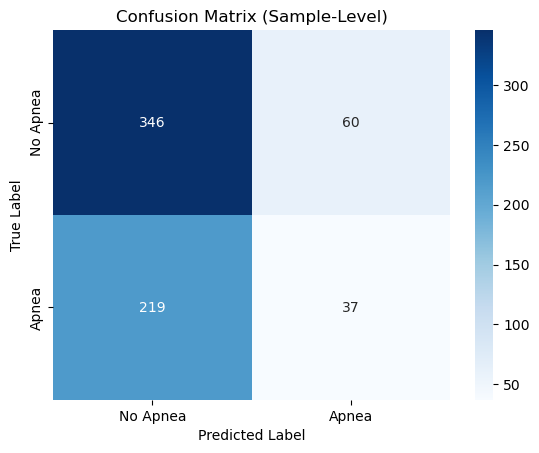

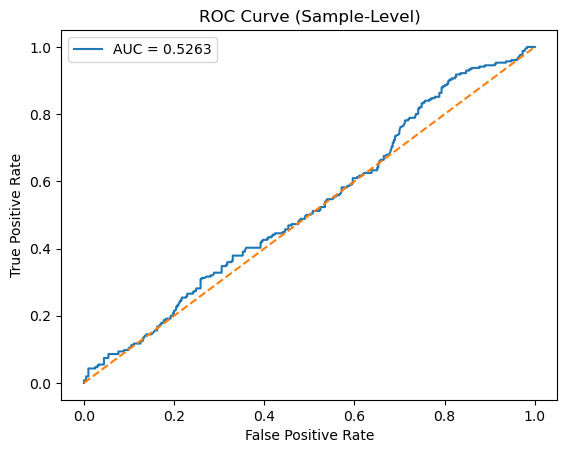


PATIENT-LEVEL PERFORMANCE

Patient-Level Metrics:
Accuracy: 0.8571
Precision: 1.0000
Recall (Sensitivity): 0.5000
Specificity: 1.0000
F1 Score: 0.6667
AUC: 0.8000


C:\Users\karth\AppData\Local\Temp\ipykernel_8064\2331335913.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_results = sample_results.groupby('patient_id').apply(aggregate_patient_results).reset_index()


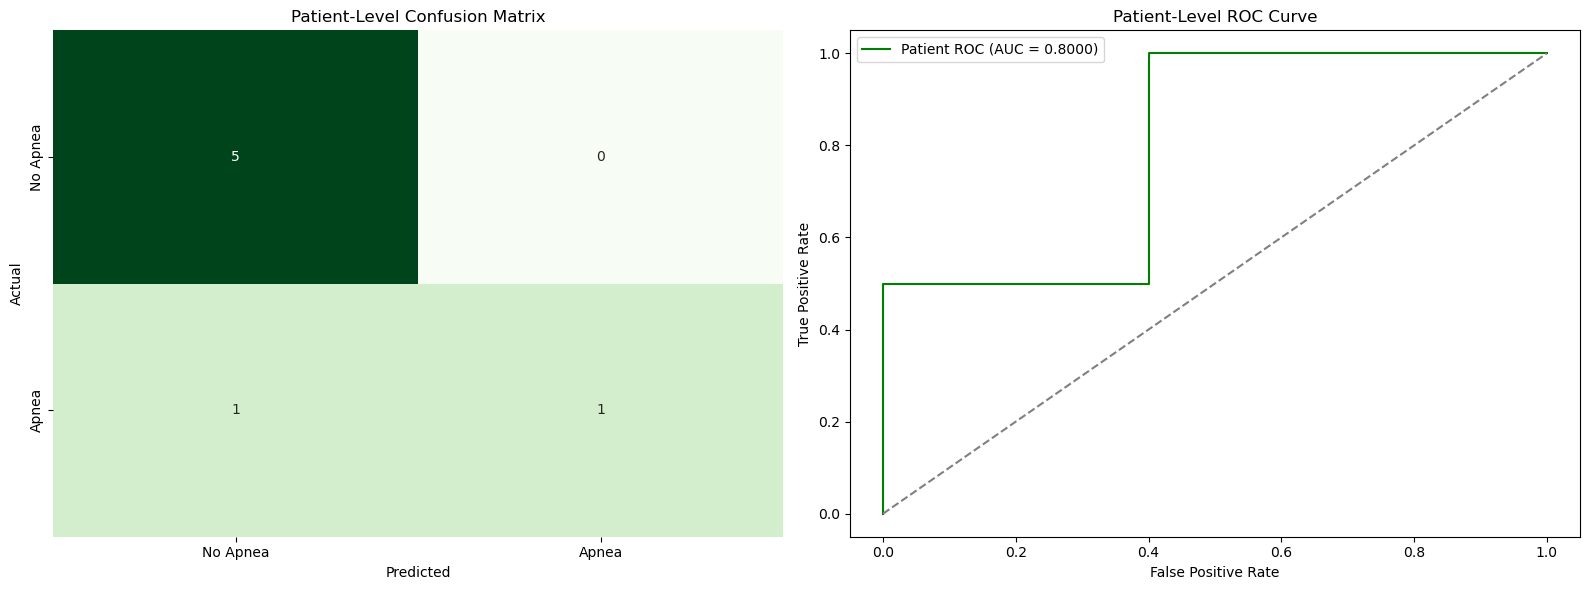

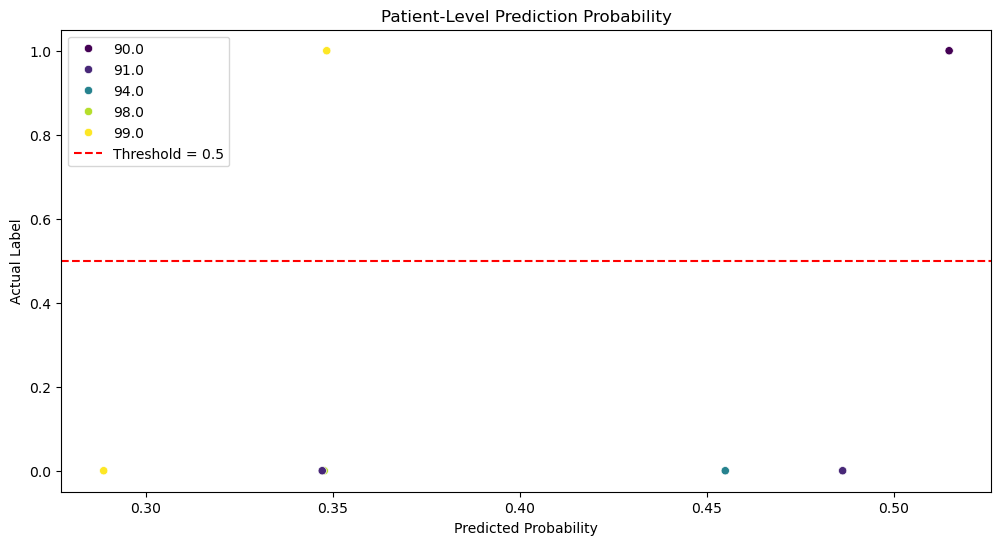

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, roc_curve, auc
)
from scipy.stats import randint, uniform
import time

# =============================================
# DATA LOADING AND PREPROCESSING
# =============================================
data = pd.read_csv('labelled_ecg_features.csv')

features = ['Mean RR Interval (ms)', 'Overall HRV', 'RMS_SD (ms)', 'pNN50 (%)', 
            'VLF Power', 'EDR Rate (breaths per min)', 'CVHR (%)']

# Enhanced feature engineering
def create_features(df):
    for feat in features:
        df[f'{feat}_patient_mean'] = df.groupby('patient_id')[feat].transform('mean')
        df[f'{feat}_patient_std'] = df.groupby('patient_id')[feat].transform('std')
        df[f'{feat}_patient_range'] = df.groupby('patient_id')[feat].transform('max') - df.groupby('patient_id')[feat].transform('min')

    # Temporal and interaction features
    df['RR_HRV_ratio'] = df['Mean RR Interval (ms)'] / (df['Overall HRV'] + 1e-6)
    df['HRV_pNN50_product'] = df['Overall HRV'] * df['pNN50 (%)']
    df['VLF_EDR_interaction'] = df['VLF Power'] * df['EDR Rate (breaths per min)']

    return df

data = create_features(data)

# Select only numeric columns for scaling and modeling
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_cols if col not in ['patient_id', 'Apnea_Label']]

# Handle missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].groupby(data['patient_id']).transform('mean'))

# Patient-aware train-test split
patient_ids = data['patient_id'].unique()
train_pids, test_pids = train_test_split(patient_ids, test_size=0.25, random_state=42)

X_train = data[data['patient_id'].isin(train_pids)][features]
X_test = data[data['patient_id'].isin(test_pids)][features]
y_train = data[data['patient_id'].isin(train_pids)]['Apnea_Label']
y_test = data[data['patient_id'].isin(test_pids)]['Apnea_Label']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================
# CLASSIFICATION MODEL TRAINING
# =============================================
print("\nStarting model training...")
start_time = time.time()

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 20),
    'max_features': ['sqrt', 'log2', 0.5, 0.7, None]
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    gb, param_dist, n_iter=50,
    cv=cv, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)

search.fit(X_train_scaled, y_train)

best_model = search.best_estimator_

print("\nModel training completed in %.1f minutes" % ((time.time() - start_time)/60))
print("Best parameters:", search.best_params_)

# =============================================
# SAMPLE-LEVEL EVALUATION
# =============================================
print("\n" + "="*50)
print("SAMPLE-LEVEL PERFORMANCE")
print("="*50)

# Predictions
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_prob > 0.5).astype(int)

# Metrics
sample_accuracy = accuracy_score(y_test, y_pred)
sample_precision = precision_score(y_test, y_pred)
sample_recall = recall_score(y_test, y_pred)
sample_f1 = f1_score(y_test, y_pred)
sample_auc = roc_auc_score(y_test, y_prob)

# Sensitivity and Specificity
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sample_sensitivity = tp / (tp + fn)
sample_specificity = tn / (tn + fp)

print("\nSample-Level Metrics:")
print(f"Accuracy: {sample_accuracy:.4f}")
print(f"Precision: {sample_precision:.4f}")
print(f"Recall (Sensitivity): {sample_recall:.4f}")
print(f"Specificity: {sample_specificity:.4f}")
print(f"F1 Score: {sample_f1:.4f}")
print(f"AUC: {sample_auc:.4f}")

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Apnea', 'Apnea'], yticklabels=['No Apnea', 'Apnea'])
plt.title("Confusion Matrix (Sample-Level)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {sample_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Sample-Level)')
plt.legend()
plt.show()

# =============================================
# PATIENT-LEVEL EVALUATION
# =============================================
print("\n" + "="*50)
print("PATIENT-LEVEL PERFORMANCE")
print("="*50)

# Prepare results for patient-level aggregation
sample_results = pd.DataFrame({
    'patient_id': data[data['patient_id'].isin(test_pids)]['patient_id'].values,
    'Actual': y_test.values,
    'Probability': y_prob
})

# Patient-level aggregation with majority voting
def aggregate_patient_results(df):
    avg_proba = df['Probability'].mean()
    patient_pred = (avg_proba > 0.5).astype(int)
    
    patient_actual = df['Actual'].mode()[0]

    return pd.Series({
        'Patient_Actual': patient_actual,
        'Patient_Predicted': patient_pred,
        'Patient_Probability': avg_proba,
        'Sample_Count': len(df)
    })

# Aggregate the patient-level results
patient_results = sample_results.groupby('patient_id').apply(aggregate_patient_results).reset_index()

# Patient-level metrics
patient_accuracy = accuracy_score(patient_results['Patient_Actual'], patient_results['Patient_Predicted'])
patient_precision = precision_score(patient_results['Patient_Actual'], patient_results['Patient_Predicted'])
patient_recall = recall_score(patient_results['Patient_Actual'], patient_results['Patient_Predicted'])
patient_f1 = f1_score(patient_results['Patient_Actual'], patient_results['Patient_Predicted'])

# Sensitivity and Specificity at patient-level
cm_patient = confusion_matrix(patient_results['Patient_Actual'], patient_results['Patient_Predicted'])
tn_p, fp_p, fn_p, tp_p = cm_patient.ravel()

patient_sensitivity = tp_p / (tp_p + fn_p)
patient_specificity = tn_p / (tn_p + fp_p)

# ROC AUC at patient level
fpr_p, tpr_p, _ = roc_curve(patient_results['Patient_Actual'], patient_results['Patient_Probability'])
patient_auc = auc(fpr_p, tpr_p)

# Display Metrics
print("\nPatient-Level Metrics:")
print(f"Accuracy: {patient_accuracy:.4f}")
print(f"Precision: {patient_precision:.4f}")
print(f"Recall (Sensitivity): {patient_recall:.4f}")
print(f"Specificity: {patient_specificity:.4f}")
print(f"F1 Score: {patient_f1:.4f}")
print(f"AUC: {patient_auc:.4f}")

# =============================================
# PATIENT-LEVEL VISUALIZATIONS
# =============================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Patient-Level Confusion Matrix
sns.heatmap(cm_patient, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[0],
            xticklabels=['No Apnea', 'Apnea'], yticklabels=['No Apnea', 'Apnea'])
axes[0].set_title('Patient-Level Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Patient-Level ROC Curve
axes[1].plot(fpr_p, tpr_p, color='green', label=f'Patient ROC (AUC = {patient_auc:.4f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title('Patient-Level ROC Curve')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()

plt.tight_layout()
plt.show()

# =============================================
# PATIENT-LEVEL PREDICTION PROBABILITIES
# =============================================
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Patient_Probability', y='Patient_Actual', data=patient_results, hue='Sample_Count', palette='viridis')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title('Patient-Level Prediction Probability')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Label')
plt.legend()
plt.show()
